### Hamiltonian Study - Evolution and Simulation
This notebook is intended to illustrate how to compute the energy expectation value for a quantum state that is produced using Hamiltonian consisting of multiple weighted Pauli strings.

The first section defines functions for creating a circuit with appended gates for the Hamiltonian term, executing those circuits, and computing the expectation value over all terms of the Hamiltonian.
The second section defines several simple functions for creating PauliEvolution circuits from the Hamiltonian Pault strings.
This is followed by a number of tests that evolve a Hamiltonian either classically or using a quantum evolution circuit and obtaining energy measures.
(There are several cells toward the end that are retained for bits of code that may be useful.)

### ------------------------------------------------------------------

In [1]:
import numpy as np
import copy
from math import sin, cos, pi
import time

from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.primitives import Estimator

from qiskit.quantum_info import Operator, Pauli
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import PauliEvolutionGate

import scipy as sc
import matplotlib.pyplot as plt


backend = Aer.get_backend('qasm_simulator')
#backend = Aer.get_backend('statevector_simulator')
noise_model = None

# Set numpy print options to format floating point numbers
np.set_printoptions(precision=3, suppress=True)

verbose = False

# Observable Helper Functions
import observables as obs

obs.verbose = False


### ------------------------------------------------------------------

### Perform Simple Time Evolution of a Quantum State
This function operates on an initial state for the specified time under the action of a given Hamiltonian.
This is an extremely simplifed version, which only works for very small times, e.g. 0.01

In [2]:
# Simulate time evolution (this is a simplified version)
def time_evolve_simple(initial_state, hamiltonian, time):

    # In a real scenario, you'd use a more sophisticated time evolution method
    # This is a simple first-order approximation  
    evolved_state = initial_state - 1j * time * np.dot(hamiltonian, initial_state)
 
    return evolved_state / np.linalg.norm(evolved_state)

### Compute theoretical energy from Hamiltonian and initial state


In [3]:
def compute_theoretical_energy(initial_state, H_terms, t=1.0):
    
    # Create the Hamiltonian matrix
    H_matrix = sum(coeff * Operator(Pauli(pauli)) for coeff, pauli in H_terms)

    # Simulate time evolution
    final_state = time_evolve_simple(initial_state, H_matrix, t)
    #print(f"... final_state = {final_state}")

    theoretical_energy = np.real(np.dot(np.conj(final_state), np.dot(H_matrix, final_state)))

    return theoretical_energy
    

### Compute theoretical energy from Hamiltonian and initial state (2nd version)
This version is returning an array of classically computed exact energies, one for each step of evolution over time.

In [4]:
def compute_theoretical_energy2(initial_state, H, time, step_size):

    if H is None:
        return [None]
        
    # Create the Hamiltonian matrix (array form)
    H_array = H.to_matrix()

    # need to convert to Statevector so the evolve() function can be used
    initial_state = Statevector(initial_state)
    
    # use this if string is passed for initialization
    #initial_state = Statevector.from_label("001100")

    # We define a slightly denser time mesh
    exact_times = np.arange(0, time+step_size, step_size)
    
    # We compute the exact evolution using the exp
    exact_evolution = [initial_state]
    exp_H = sc.linalg.expm(-1j * step_size * H_array)
    for time in exact_times[1:]:
        print('.', end="")
        exact_evolution.append(exact_evolution[-1].evolve(exp_H))

    # Having the exact state vectors, we compute the exact evolution of our operators’ expectation values.
    exact_energy = np.real([sv.expectation_value(H) for sv in exact_evolution])
    
    return exact_energy, exact_times


### ------------------------------------------------------------------

### Create Classical Test Evolution Circuit 
Create a circuit that will be measured and that will have its energy computed against a specific Hamiltonian. We start with an initial state and apply classical simple time evolution to it. The resulting state will be used to initialize the simplest quantum circuit with that state on its output.

In [5]:
def create_classical_test_circuit(initial_state, H_terms, t=1.0):
    
    n_qubits = len(H_terms[0][1])
    qc = QuantumCircuit(n_qubits)
    
    # Create the Hamiltonian matrix
    H_matrix = sum(coeff * Operator(Pauli(pauli)) for coeff, pauli in H_terms)
    
    # Simulate time evolution
    final_state = time_evolve_simple(initial_state, H_matrix, t)

    if verbose:
        print(f"... initial_state = {initial_state}")
        print(f"... H = {H_matrix}")
        print(f"... final_state = {final_state}")

        #print(f"... H * final_state = {np.dot(H_matrix, final_state)}")
        #print(f"... conf of final_state = {np.conj(final_state)}")

    # Initialize the circuit with the given state vector
    qc.initialize(final_state, qc.qubits)

    return qc, final_state

### Estimate Energy Classically 
Create a classical circuit initialized to the initial state and its energy computed against a specific Hamiltonian. 

In [6]:
def estimate_energy_classical(initial_state, H_terms, t=1.0):
    
    qc, final_state = create_classical_test_circuit(initial_state, H_terms, t=t)
    if verbose: print(f"Test circuit = \n", qc)
       
    # Obtain, by executing the circuit on the backend and compute the expectation value, the energy
    total_energy = obs.estimate_expectation(backend, qc, H_terms)
    #total_energy = obs.estimate_expectation_with_estimator(backend, qc, H_terms)
  
    return total_energy

### ------------------------------------------------------------------

### Define Pauli Evolution Circuit
This function is used to create a circuit, given an array of Pauli terms, that performs Trotterized state evolution for time t.

In [7]:
def create_pauli_evolution_circuit(pauli_terms, time=1.0):
    """
    Create a QuantumCircuit with PauliEvolution gate from Pauli terms.
    
    Args:
    pauli_terms (list): List of tuples, each containing (coefficient, Pauli string)
    time (float): Evolution time (default is 1.0)
    
    Returns:
    QuantumCircuit: Circuit with PauliEvolution gate
    """
    
    # Determine the number of qubits
    num_qubits = len(pauli_terms[0][1])  # Length of any Pauli string
    
    # Convert to SparsePauliOp
    sparse_pauli_op = obs.convert_to_sparse_pauli_op(pauli_terms)
    
    # Create the PauliEvolutionGate
    evo_gate = PauliEvolutionGate(sparse_pauli_op, time=time)
    
    # Create a quantum circuit and apply the evolution gate
    qc = QuantumCircuit(num_qubits)
    qc.append(evo_gate, range(num_qubits))
    
    return qc

### Create Quantum Test Evolution Circuit 
Here, we create a circuit that will be measured and that will have its energy computed against a specific Hamiltonian. We start with an initial state and apply quantum Hamiltonian evolution to it. The resulting state will be used for testing in subsequent cells.

We create it using a generated quantum circuit to perform the evolution.

In [8]:
def create_quantum_test_circuit(initial_state, H_terms, step, step_size):

    initial_state = normalize(np.array(initial_state))
    
    n_qubits = len(H_terms[0][1])
    qc = QuantumCircuit(n_qubits)

    # Initialize the circuit with the given state vector
    qc.initialize(initial_state, qc.qubits)
    
    qc_ev = create_pauli_evolution_circuit(H_terms, time = step_size)
    
    if verbose: print(f"... evolution circuit = \n{qc_ev}")

    # Need to decompose here, so we do not have references to PauliEvolution gates, which cannot be copied
    qc_ev = qc_ev.decompose().decompose()

    # use compose, instead of append, so that the copy used in expectation computation can function correctly
    for k in range(step):
        qc.compose(qc_ev, inplace=True)
    
    if verbose: print(f"... after compose, saved circuit = \n{qc}")
    
    return qc

def normalize(array):
    # Calculate the sum of squares of the elements
    sum_of_squares = np.sum(np.square(array))
    # Calculate the normalization factor
    normalization_factor = np.sqrt(sum_of_squares)
    # Normalize the array
    normalized_array = array / normalization_factor
    return normalized_array


### Estimate Multiple Observables
Create a quantum circuit with the given initial state, add Trotter evolution gates and rotations defined by the given Hamiltonians, execute the circuits, and process the measurement results to return the value of each observable.

In [9]:
# compute expectation value for multiple observables after Trotterized evolution to given step count
def estimate_multiple_observables(initial_state, H_terms_multiple, step, step_size, num_shots=10000):

    # determine number of qubits from the Pauli string in the first term of the first list of Hamiltonians
    num_qubits = len(H_terms_multiple[0][0][1])
    
    qc = QuantumCircuit(num_qubits) 

    # create a quantum circuit from the first of the Hamiltonian in the first element of the array
    qc = create_quantum_test_circuit(initial_state, H_terms_multiple[0], step, step_size)

    #print(qc)
    
    # Obtain all the estimated observables by executing the circuit on the backend and compute each observable
    observables = obs.estimate_expectation2(backend, qc, H_terms_multiple, num_shots=num_shots)
  
    return observables
    

### ------------------------------------------------------------------

### Define Test Hamiltonians and Initial State

In [10]:

# Return a Hamiltonian of the specified type: return terms array and SparsePauliOp equivalent
def get_hamiltonian(type: str, num_qubits: int):  
    H_terms = None
    H = None
    match type:
        case 'test-1':
            H_terms = [
                (0.5, 'ZI'),
                (0.3, 'XX'),
                (-0.1, 'YY'),
            ]
        case 'test-2':
            H_terms =  obs.swap_pauli_list([
                ('ZI', 0.5),
                ('XX', 0.3),
                ('YY', -0.1)
            ])
        case 'test-4':
            H_terms =  obs.swap_pauli_list([
                ('XXII', 0.5),
                ('IYYI', 0.3),
                ('IIZZ', 0.4),
                ('XYII', 0.2),
                ('IIYX', 0.6),
                ('IZXI', 0.1),
                ('XIII', 0.7)
            ])
        case "ising":        # the Ising Hamiltonian
            H = get_ising_hamiltonian(L=num_qubits, J=0.2, h=1.2, alpha=pi / 8)
            H_terms = obs.swap_pauli_list(H.to_list())

    if H is None:
        H = obs.convert_to_sparse_pauli_op(H_terms)

    return H_terms, H

# classical simple Ising is ZZ
# TFIM ZZ + X  is transverse field
# + longitudinal field -> ZZ, X, and Z
def get_ising_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

######## Specify the Hamiltonian to use for execution

num_qubits = 4

#H_type = "test-1"
#H_type = "test-4"
H_type = "ising"

H_terms, H = get_hamiltonian(H_type, num_qubits)
print(f"... using H_terms = {H_terms}")
print(f"    SparsePauliOp = ", H)

"""
groups = obs.group_commuting_terms_2(H_terms_swapped)
for i, group in enumerate(groups):
    print(f"Group {i+1}:")
    for pauli, coeff in group:
        print(f"  {pauli}: {coeff}")
"""
pass


... using H_terms = [((-0.2+0j), 'IIZZ'), ((-0.2+0j), 'IZZI'), ((-0.2+0j), 'ZZII'), ((-0.4592201188381077+0j), 'IIIZ'), ((-0.4592201188381077+0j), 'IIZI'), ((-0.4592201188381077+0j), 'IZII'), ((-0.4592201188381077+0j), 'ZIII'), ((-1.1086554390135441+0j), 'IIIX'), ((-1.1086554390135441+0j), 'IIXI'), ((-1.1086554390135441+0j), 'IXII'), ((-1.1086554390135441+0j), 'XIII')]
    SparsePauliOp =  SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIIX', 'IIXI', 'IXII', 'XIII'],
              coeffs=[-0.2  +0.j, -0.2  +0.j, -0.2  +0.j, -0.459+0.j, -0.459+0.j, -0.459+0.j,
 -0.459+0.j, -1.109+0.j, -1.109+0.j, -1.109+0.j, -1.109+0.j])


### Define Other Relevant Observables

In [11]:

# Define additional Hamiltonian terms for other Ising observables
H_terms_spin_correlation = [(0.2,'IIIIZZ'), (0.2,'IIIZZI'), (0.2,'IIZZII'), (0.2,'IZZIII'), (0.2,'ZZIIII')]
H_terms_magnetization = [(1,'IIIIIZ'), (1,'IIIIZI'), (1,'IIIZII'), (1,'IIZIII'), (1,'IZIIII'), (1, 'ZIIIII')]

print(H_terms_spin_correlation)
print(H_terms_magnetization)

#L = 6
L = num_qubits

print("****")
magnetization_op = SparsePauliOp.from_sparse_list(
    #[("Z", [i], 1.0) for i in range(0, 6)], num_qubits=6
    [("Z", [i], 1.0) for i in range(0, L)], num_qubits=L
)
print("magnetization: ", magnetization_op)

print("****")
correlation_op = SparsePauliOp.from_sparse_list(
    [("ZZ", [i, i + 1], 1.0) for i in range(0, L - 1)], num_qubits=L
) / (L - 1)
print("mean spin correlation", correlation_op)

H_terms_magnetization = obs.swap_pauli_list(magnetization_op.to_list())
H_terms_spin_correlation = obs.swap_pauli_list(correlation_op.to_list())

print(H_terms_spin_correlation)
print(H_terms_magnetization)

H_terms_multiple = [H_terms, H_terms_spin_correlation, H_terms_magnetization] #pass this into a function, and check if each term is in.
H_terms_names = ["Energy", "Spin Correlation", "Magnetization"]


[(0.2, 'IIIIZZ'), (0.2, 'IIIZZI'), (0.2, 'IIZZII'), (0.2, 'IZZIII'), (0.2, 'ZZIIII')]
[(1, 'IIIIIZ'), (1, 'IIIIZI'), (1, 'IIIZII'), (1, 'IIZIII'), (1, 'IZIIII'), (1, 'ZIIIII')]
****
magnetization:  SparsePauliOp(['IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
****
mean spin correlation SparsePauliOp(['IIZZ', 'IZZI', 'ZZII'],
              coeffs=[0.333+0.j, 0.333+0.j, 0.333+0.j])
[((0.3333333333333333+0j), 'IIZZ'), ((0.3333333333333333+0j), 'IZZI'), ((0.3333333333333333+0j), 'ZZII')]
[((1+0j), 'IIIZ'), ((1+0j), 'IIZI'), ((1+0j), 'IZII'), ((1+0j), 'ZIII')]


### ------------------------------------------------------------------

### Define Initial State

In [12]:

# initialize 0 state based on width of first term's Pauli string
dimension = len(H_terms[0][1])
initial_state = np.zeros((2**dimension), dtype=complex)
initial_state[0] = 1  # Set the amplitude for |00> state
print(initial_state)


[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


### Perform Test 1 - Classical Evolution

In [13]:
print("========= Classical Calculation of Energy\n")
print(H_terms)
print(initial_state)

total_evolution_time = 0.5

# Compute theoretical energy, using simple 1st order evolution
# This returns an increasing erroneous result unless time is very small < 0.1
theoretical_energy = compute_theoretical_energy(initial_state, H_terms, t=total_evolution_time)

# Compute the total energy using simple 1st order evolution incorporated into a quantum circuit
total_energy = estimate_energy_classical(initial_state, H_terms, t=total_evolution_time)

# Compute the theoretical energy using an exact, but slower, classical computation
theoretical_energies_exact, time_values = compute_theoretical_energy2(initial_state, H, total_evolution_time, total_evolution_time)

print("")
print(f"For evolution time = {total_evolution_time} :")
print("")
print(f"  Estimated energy: {total_energy}")
print(f"  Theoretical energy: {theoretical_energy}")
print(f"  Theoretical energy (exact): {theoretical_energies_exact[0]}")
print("")


========= Classical Calculation of Energy

[((-0.2+0j), 'IIZZ'), ((-0.2+0j), 'IZZI'), ((-0.2+0j), 'ZZII'), ((-0.4592201188381077+0j), 'IIIZ'), ((-0.4592201188381077+0j), 'IIZI'), ((-0.4592201188381077+0j), 'IZII'), ((-0.4592201188381077+0j), 'ZIII'), ((-1.1086554390135441+0j), 'IIIX'), ((-1.1086554390135441+0j), 'IIXI'), ((-1.1086554390135441+0j), 'IXII'), ((-1.1086554390135441+0j), 'XIII')]
[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
.
For evolution time = 0.5 :

  Estimated energy: (-3.552165782050731+0j)
  Theoretical energy: -3.547381147985107
  Theoretical energy (exact): -2.436880475352431



### ------------------------------------------------------------------

### Perform Test 2 - Quantum Evolution

In [14]:
print("========= Quantum Simulation of Evolution and Calculation of Observables\n")
print(H)
print(H_terms)
print(initial_state)

# total evolution time
total_evolution_time = 6

# for Trotterized evolution, specify size of each step
step_size = 0.5

# compute number of trotter steps 
# num_steps = int(total_evolution_time / step_size)

########### Obtain multiple observables for successively longer evolution times

observables_list = []

print(f"... getting exact energies")

# Create array of theoretical energies (for comparison)
# We compute this in an array function so that we can do the matrix conversion just once for all the steps
theoretical_energies, time_values = compute_theoretical_energy2(initial_state, H, total_evolution_time, step_size)

print(f"... got exact energies {theoretical_energies}")

# loop over successively longer time steps to create arrays of obeservable values
for step in range(len(time_values)):
    print(".", end="")
    
    # compute observables at this step and append results to the list
    observables = estimate_multiple_observables(initial_state, H_terms_multiple, step, step_size)
    observables_list.append(observables)
    
print("")


========= Quantum Simulation of Evolution and Calculation of Observables

SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIIX', 'IIXI', 'IXII', 'XIII'],
              coeffs=[-0.2  +0.j, -0.2  +0.j, -0.2  +0.j, -0.459+0.j, -0.459+0.j, -0.459+0.j,
 -0.459+0.j, -1.109+0.j, -1.109+0.j, -1.109+0.j, -1.109+0.j])
[((-0.2+0j), 'IIZZ'), ((-0.2+0j), 'IZZI'), ((-0.2+0j), 'ZZII'), ((-0.4592201188381077+0j), 'IIIZ'), ((-0.4592201188381077+0j), 'IIZI'), ((-0.4592201188381077+0j), 'IZII'), ((-0.4592201188381077+0j), 'ZIII'), ((-1.1086554390135441+0j), 'IIIX'), ((-1.1086554390135441+0j), 'IIXI'), ((-1.1086554390135441+0j), 'IXII'), ((-1.1086554390135441+0j), 'XIII')]
[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
... getting exact energies
............... got exact energies [-2.437 -2.437 -2.437 -2.437 -2.437 -2.437 -2.437 -2.437 -2.437 -2.437
 -2.437 -2.437 -2.437]
.............


### ------------------------------------------------------------------

### Plot Results
Generate a plot showing the expectation value of multiple observables over successively longer Trotterized evolution times

/home/sjohri/miniconda3/envs/benchmarks/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/sjohri/miniconda3/envs/benchmarks/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


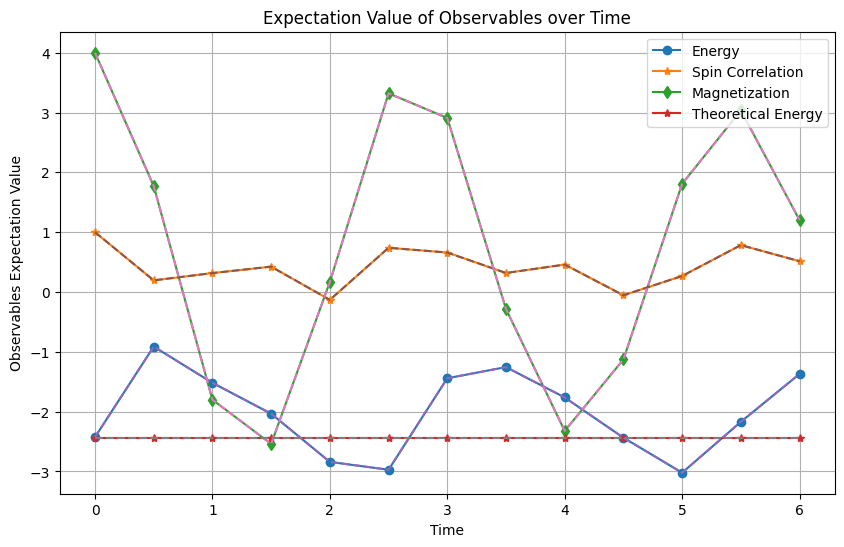

In [15]:

########### Transform Data for Plotting

observables_values_list = []

# pre-populate the observables value arrays with empty arrays
for i in range(len(H_terms_multiple)):
    observables_values_list.append([])

# for each step, put the values of the computed observables into the values array, for plotting
for step in range(len(time_values)):
    for j in range(len(observables_list[step])):
        observables_values_list[j].append(observables_list[step][j])

########### Plot Results

# Plot the results
plt.figure(figsize=(10, 6))

marker=['o', '*', 'd', '1', '2']

#####
for i in range(len(H_terms_multiple)):
    plt.plot(time_values, observables_values_list[i], label= H_terms_names[i], marker=marker[i])

plt.plot(time_values, theoretical_energies, label='Theoretical Energy', marker='*')

#####
for j in range(len(H_terms_multiple)):
    plt.plot(time_values, observables_values_list[j], linestyle='--')
    
plt.plot(time_values, theoretical_energies, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Observables Expectation Value')
plt.title('Expectation Value of Observables over Time')
plt.legend()
plt.grid(True)
plt.show()


### ------------------------------------------------------------------

### Test Commuting Groups Performance improvement 
Generate a plot showing the expectation value of multiple observables over successively longer Trotterized evolution times

In [16]:
"""
num_qubits = 6

#H_type = "test-1"
#H_type = "test-4"
H_type = "ising"

H_terms, H = get_hamiltonian(H_type, num_qubits)
print(f"... using H_terms = {H_terms}")
print(f"    SparsePauliOp = ", H)


H_terms_multiple = [H_terms, H_terms_spin_correlation, H_terms_magnetization] #pass this into a function, and check if each term is in.
H_terms_names = ["Energy", "Spin Correlation", "Magnetization"]

#H_terms_multiple = [H_terms, H_terms_magnetization] #pass this into a function, and check if each term is in.
#H_terms_names = ["Energy", "Magnetization"]
"""

#obs.verbose = True

step = 2
step_size = 0.5

ts = time.time()

observables = estimate_multiple_observables(initial_state, H_terms_multiple, step, step_size, num_shots=10000)

print(f"... elapsed time = {round(time.time()-ts, 3)}")

print(observables)

# Get groups for original Hamiltonian
groups = obs.group_commuting_terms_2(obs.swap_pauli_list(H_terms))


print("\n ============= H_terms:")
print(H_terms)

print("\n ============= H_terms grouped:")
for i, group in enumerate(groups):
    print(f"Group {i+1}:")
    for coeff, pauli in group:
        print(f"  {coeff}: {pauli}")
        
for i, group in enumerate(groups):
    print(f"Group {i+1}:")
    #for pauli, coeff in group:
    for j, term in enumerate(group):
        print(f"  {pauli}: {coeff}")
        group[j] = (coeff, pauli)
        
for i, group in enumerate(groups):
    print(f"Group {i+1}:")
    for coeff, pauli in group:
        print(f"  {coeff}: {pauli}")
        




... elapsed time = 0.445
[(-1.549319272032167+0j), (0.3124+0j), (-1.7894+0j)]

 ============= H_terms:
[((-0.2+0j), 'IIZZ'), ((-0.2+0j), 'IZZI'), ((-0.2+0j), 'ZZII'), ((-0.4592201188381077+0j), 'IIIZ'), ((-0.4592201188381077+0j), 'IIZI'), ((-0.4592201188381077+0j), 'IZII'), ((-0.4592201188381077+0j), 'ZIII'), ((-1.1086554390135441+0j), 'IIIX'), ((-1.1086554390135441+0j), 'IIXI'), ((-1.1086554390135441+0j), 'IXII'), ((-1.1086554390135441+0j), 'XIII')]

 ============= H_terms grouped:
Group 1:
  IIZZ: (-0.2+0j)
  IZZI: (-0.2+0j)
  ZZII: (-0.2+0j)
  IIIZ: (-0.4592201188381077+0j)
  IIZI: (-0.4592201188381077+0j)
  IZII: (-0.4592201188381077+0j)
  ZIII: (-0.4592201188381077+0j)
Group 2:
  IIIX: (-1.1086554390135441+0j)
  IIXI: (-1.1086554390135441+0j)
  IXII: (-1.1086554390135441+0j)
  XIII: (-1.1086554390135441+0j)
Group 1:
  (-1.1086554390135441+0j): XIII
  (-1.1086554390135441+0j): XIII
  (-1.1086554390135441+0j): XIII
  (-1.1086554390135441+0j): XIII
  (-1.1086554390135441+0j): XIII
  